# Pittsburgh Commutes by Neighborhood 🚗
Computing commutability scores per Pittsburgh neighborhood.

## 🔢 Data

In [210]:
import pandas as pd
import numpy as np

# read census data
commute = pd.read_csv("data/SNAP/Neighborhoods_with_SNAP_data.csv")

# make easier column names
commute['name'] = commute['Neighborhood_2010_HOOD']             # neighborhood name
commute['drive'] = commute['SNAP_All_csv_Commute_to_Work__D']   # drive to work alone
commute['carpool'] = commute['SNAP_All_csv_Commute_to_Work__C'] # carpool/vanpool
commute['public'] = commute['SNAP_All_csv_Commute_to_Work__P']  # public transit
commute['taxi'] = commute['SNAP_All_csv_Commute_to_Work__T']    # taxi
commute['motor'] = commute['SNAP_All_csv_Commute_to_Work__M']   # motorcycle
commute['bike'] = commute['SNAP_All_csv_Commute_to_Work__B']    # bike
commute['walk'] = commute['SNAP_All_csv_Commute_to_Work__W']    # walk
commute['other'] = commute['SNAP_All_csv_Commute_to_Work__O']   # other

# clean data
commute = commute.fillna(0)

## 📊 Metrics

In [211]:
# constants to determine value of method
# best values are 1, okay are 0.5, bad or null are 0.25
good = 1   # bike, walk
okay = 0.5 # carpool, public transit
bad = 0.25 # drive, taxi, motorcycle, other

# convert percent value to float
def convert(value):
    value = str(value)
    value = value.replace('%','')
    return float(value)

# iterate through rows, calculate commutability score
for idx, row in commute.iterrows():
    score = convert(commute.loc[idx,'bike']) + convert(commute.loc[idx, 'walk']) # good methods
    score += okay*(convert(commute.loc[idx, 'carpool']) + convert(commute.loc[idx, 'public'])) # okay methods
    score += bad*(convert(commute.loc[idx, 'drive']) + convert(commute.loc[idx, 'taxi']) + convert(commute.loc[idx, 'motor']) + convert(commute.loc[idx, 'other'])) # bad methods
    commute.at[idx,'score'] = score # set neighborhood's commutability score

# view results
commute[['name', 'score']]

,name,score
0,Central Oakland,76.575
1,North Oakland,70.200
2,West Oakland,61.400
3,Crawford-Roberts,36.400
4,Strip District,32.050
...,...,...
85,Chartiers City,30.625
86,Ridgemont,37.350
87,West End,33.200
88,California-Kirkbride,45.550


## 🗺 Visualization

<AxesSubplot:>

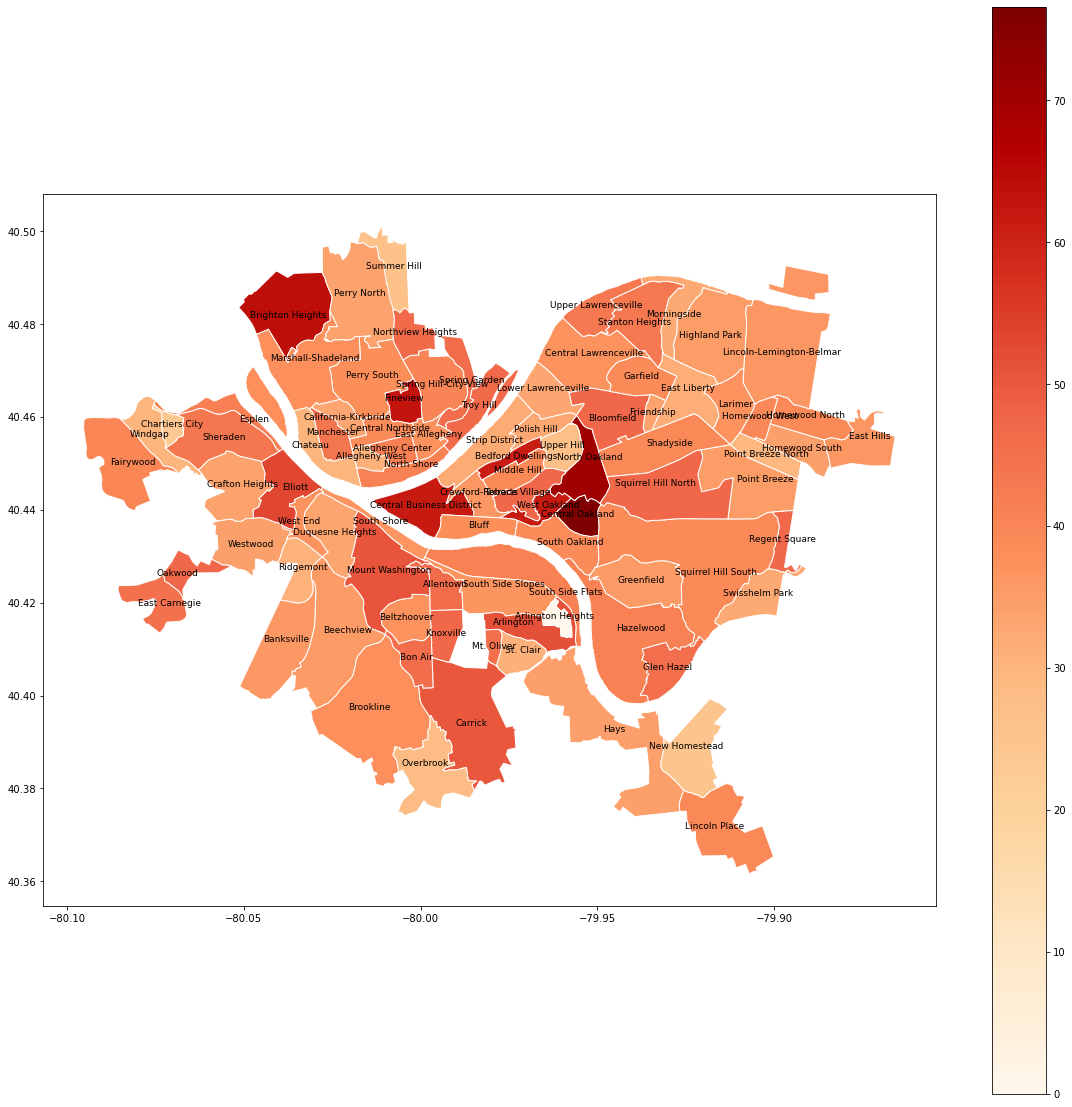

In [212]:
import geopandas as gpd
%matplotlib inline
from matplotlib import pyplot as plt

# read in map data
pgh = gpd.read_file("data/Neighborhoods/Neighborhoods_.shp")

# project map data to lat/lon
pgh['geometry'] = pgh['geometry'].to_crs(epsg=4326)

# add neighborhood labels to map
def label_map():
    pgh['coords'] = pgh['geometry'].apply(lambda x: x.representative_point().coords[:])
    pgh['coords'] = [coords[0] for coords in pgh['coords']]
    for idx, row in pgh.iterrows():
        plt.annotate(text = row['hood'], xy=row['coords'],
                     horizontalalignment='center', size=9)

# add scores to map
pgh['score'] = commute['score']

# plot map
fig,ax = plt.subplots(figsize = (20,20)) # plot size
label_map()
pgh.plot(ax=ax, column='score', cmap='OrRd', edgecolor="white", legend='True')